# Setup, Constants, and Imports

In [1]:
import os
import sys
import logging
import pandas as pd
import numpy as np

## Notebook Configs

In [2]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = False # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

## Constants

In [3]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "lp_topic_modelling" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "3_modelling" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

## Clone and Pull Latest from Repository - Colab Specific

In [4]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../../') # TODO: UPDATE THIS TO ROOT OF REPO
    
    !pip install -r requirements.txt

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Load Data

In [5]:
gs_discussion_df = pd.read_csv('data/processed/Goldman Sachs/discussion_df.csv')
gs_qna_df = pd.read_csv('data/processed/Goldman Sachs/qna_df.csv')
jp_discussion_df = pd.read_csv('data/processed/JP Morgan/discussion_df.csv')
jp_qna_df = pd.read_csv('data/processed/JP Morgan/qna_df.csv')

In [6]:
gs_discussion_df.head()

,speaker,role,company,content,quarter,year
0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,"CEO, Chairman",Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,"Chief Strategy Ofﬁcer, Head of Investor Relations",Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [7]:
gs_qna_df.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,NaN,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,NaN,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,NaN,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [8]:
gs_qna_df.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,NaN,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,NaN,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,NaN,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [9]:
jp_qna_df.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


# Topic Modelling

In [10]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 688.1 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
from src.utils.common_helpers import read_list_from_text_file

gs_stopwords = set(read_list_from_text_file('src/data_processing/goldman_sachs_topic_modelling_stopwords.txt'))
# gs_stopwords = set()

In [12]:
from src.utils.common_helpers import read_yaml_file
abbreviations = read_yaml_file('src/abbreviations.yaml')

In [13]:
grouped_gs_qna_df = gs_qna_df.groupby(['question_answer_group_id', 'quarter', 'year'], as_index = False).agg({ 'content': ' '.join })

In [14]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except OSError:
    print("SpaCy 'en_core_web_sm' model not found. Please run: python -m spacy download en_core_web_sm")
    exit()

all_stop_words = nlp.Defaults.stop_words.union(gs_stopwords)

def preprocess_text(text: str, stop_words: set, abbreviations: dict) -> str:
    if not isinstance(text, str):
        return ""
    
    processed_text = text.lower()
    processed_text = re.sub(r'[-_]+', ' ', processed_text).strip()
    
    sorted_phrases = sorted(abbreviations.items(), key=lambda item: len(item[1]), reverse=True)
    
    for abbrev, phrase in sorted_phrases:
        processed_text = re.sub(r'\b' + re.escape(phrase.lower()) + r'\b', abbrev.lower(), processed_text)

    processed_text = re.sub(r'\b\d+\b', '', processed_text).strip()

    doc = nlp(processed_text)

    tokens = []
    for token in doc:
        if token.text not in stop_words or token.text in abbreviations.keys():
            tokens.append(token.lemma_) # Lemmatize the token (abbreviations won't change)

    return " ".join(tokens)


In [15]:
preprocess_text("hello there this is the first quarter earnings report and i a questions about the you've you've", all_stop_words, abbreviations)

'hello 1q earning question'

In [16]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def vectorize_text(data_series, max_df=0.95, min_df=5, stop_words=None, ngram_range=(1, 1)):
    """
    Performs TF-IDF vectorization on a given text series.
    Args:
        data_series (pd.Series): A pandas Series containing preprocessed text content.
        max_df (float): When building the vocabulary ignore terms that have a document
                        frequency strictly higher than the given threshold (corpus-specific stop words).
        min_df (int): When building the vocabulary ignore terms that have a document
                      frequency strictly lower than the given threshold.
        stop_words (str or list, optional): 'english' for a built-in stop word list,
                                            a list of custom stop words, or None.
    Returns:
        tuple: A tuple containing:
            - dtm (scipy.sparse.csr_matrix): The Document-Term Matrix.
            - vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
    """
    print("\nStarting Phase 3: Vectorization (TF-IDF)...")
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, ngram_range=ngram_range)
    dtm = vectorizer.fit_transform(data_series)
    print(f"TF-IDF Vectorization complete. Document-Term Matrix shape: {dtm.shape}")
    return dtm, vectorizer

def display_topics(model, feature_names, no_top_words, file=None):
    """
    Prints or writes the top words for each topic from an LDA model.
    Args:
        model (LatentDirichletAllocation): The fitted LDA model.
        feature_names (list): List of feature names (words) from the vectorizer.
        no_top_words (int): The number of top words to display for each topic.
        file (file object, optional): If provided, topics will be written to this file.
                                      Otherwise, they will be printed to the console.
    """
    for topic_idx, topic in enumerate(model.components_):
        topic_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        if file:
            file.write(f"\nTopic {topic_idx + 1}:\n")
            file.write(f"{topic_words}\n")
        else:
            print(f"\nTopic {topic_idx + 1}:")
            print(topic_words)

def run_lda_topic_modeling(dtm, vectorizer, num_topics_range, output_dir="data/temp/leslie_topic_modelling_fine_tuning", no_top_words=10, df_to_update=None):
    """
    Performs LDA topic modeling for a range of topic numbers and saves the results.
    Args:
        dtm (scipy.sparse.csr_matrix): The Document-Term Matrix from TF-IDF vectorization.
        vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
        num_topics_range (list): A list of integers representing the number of topics to experiment with.
        output_dir (str): Directory to save the topic modeling output files.
        no_top_words (int): The number of top words to display for each topic.
        df_to_update (pd.DataFrame, optional): The DataFrame to which dominant topics will be
                                                assigned. If None, dominant topics won't be added.
    """
    print("\nStarting Phase 4: Topic Modeling (LDA) for a range of topics...")

    feature_names = vectorizer.get_feature_names_out()

    for num_topics in num_topics_range:
        output_filename = f"{output_dir}/lda_topics_k{num_topics}.txt"
        print(f"\n--- Processing with {num_topics} topics. Outputting to {output_filename} ---")

        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(f"--- LDA Topic Model with {num_topics} Topics ---\n\n")

            lda = LatentDirichletAllocation(n_components=num_topics,
                                            max_iter=10,
                                            learning_method='online',
                                            learning_decay=0.7,
                                            random_state=42,
                                            n_jobs=-1,
                                            evaluate_every=10)

            lda.fit(dtm)
            f.write(f"LDA model fitting complete for {num_topics} topics.\n\n")

            f.write("\nInterpreting Topics:\n")
            display_topics(lda, feature_names, no_top_words, file=f)

            if df_to_update is not None:
                topic_distribution = lda.transform(dtm)
                df_to_update[f'dominant_topic_k{num_topics}'] = np.argmax(topic_distribution, axis=1)

                print(f"\nExample: Documents with their dominant topic (first 5 rows) for k={num_topics}:")
                for i in range(min(5, len(df_to_update))):
                    original_content = df_to_update.loc[i, 'content']
                    truncated_content = (original_content[:200] + '...') if len(original_content) > 200 else original_content
                    dominant_topic = df_to_update.loc[i, f'dominant_topic_k{num_topics}']
                    print(f"Doc {i}: Topic {dominant_topic} - Content: \"{truncated_content}\"")

grouped_gs_qna_df['preprocessed_content'] = grouped_gs_qna_df['content'].apply(lambda x: preprocess_text(x, all_stop_words, abbreviations))
dtm_matrix, tfidf_vectorizer = vectorize_text(grouped_gs_qna_df['preprocessed_content'], ngram_range=(1, 3))

# num_topics_range = [8, 9, 10]
# num_topics_range = [2, 5, 8, 11, 14, 17, 20, 23]
num_topics_range = [5, 8, 11, 14]
run_lda_topic_modeling(dtm_matrix, tfidf_vectorizer, num_topics_range, df_to_update=grouped_gs_qna_df, )

print("\nProcessing complete. Check the 'data/temp/leslie_topic_modelling_fine_tuning' directory for output files.")
print("\nUpdated DataFrame with dominant topics (first 5 rows):")
print(grouped_gs_qna_df.head())


Starting Phase 3: Vectorization (TF-IDF)...
TF-IDF Vectorization complete. Document-Term Matrix shape: (149, 1022)

Starting Phase 4: Topic Modeling (LDA) for a range of topics...

--- Processing with 5 topics. Outputting to data/temp/leslie_topic_modelling_fine_tuning/lda_topics_k5.txt ---

Example: Documents with their dominant topic (first 5 rows) for k=5:
Doc 0: Topic 4 - Content: " hi. thanks very much. so, i appreciate the $1 billion harvesting out of the balance sheet pe and the other $1 billion coming up. so, it's a partial answer to the question. but in the backdrop that we..."
Doc 1: Topic 4 - Content: " hi, there. curious, you mentioned being optimistic about m&a  in the back-half, particularly on the strategic side. i'm curious what and how you -- what you're seeing that gives you that conﬁdence. o..."
Doc 2: Topic 4 - Content: " hi. thanks very much. it's a tough one because you are deﬁnitely executing on a lot of the objectives you laid out. and of course, the sustainabi

In [17]:
# (Conceptual - requires FinBERT model loading and appropriate tokenization)

import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
def get_finbert_embeddings(texts):
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModel.from_pretrained("ProsusAI/finbert")

    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    return outputs.last_hidden_state[:, 0, :].numpy()

def run_finbert_topic_clustering(df, num_topics_range, output_dir="data/temp/finbert_topic_clustering"):
    print("\nStarting Topic Clustering using FinBERT embeddings...")

    # 1. Get FinBERT embeddings for your documents
    document_embeddings = get_finbert_embeddings(df['content'].tolist())
    print(f"Generated {document_embeddings.shape[0]} document embeddings of size {document_embeddings.shape[1]}.")

    for num_topics in num_topics_range:
        print(f"\n--- Processing with {num_topics} clusters (topics) using FinBERT embeddings ---")
        kmeans = KMeans(n_clusters=num_topics, random_state=42, n_init=10) # n_init for stability
        kmeans.fit(document_embeddings)
        df[f'finbert_dominant_topic_k{num_topics}'] = kmeans.labels_

        # 2. Interpret topics (example: finding top words per cluster using TF-IDF on cluster documents)
        print(f"\nInterpreting Clusters for k={num_topics}:")
        for i in range(num_topics):
            cluster_docs = df[df[f'finbert_dominant_topic_k{num_topics}'] == i]['content']
            if len(cluster_docs) > 0:
                # Use TF-IDF to find important words in this cluster
                tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
                tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_docs)
                feature_names = tfidf_vectorizer.get_feature_names_out()
                sums_tfidf = tfidf_matrix.sum(axis=0)
                # Get top words
                top_words_indices = sums_tfidf.argsort()[0, ::-1][:10]
                top_words = [feature_names[idx] for idx in top_words_indices.tolist()[0]]
                print(f"Cluster {i} (Top Words): {', '.join(top_words)}")
            else:
                print(f"Cluster {i}: No documents in this cluster.")

        print(f"\nExample: Documents with their dominant topic (first 5 rows) for k={num_topics}:")
        for i in range(min(5, len(df))):
            original_content = df.loc[i, 'content']
            truncated_content = (original_content[:200] + '...') if len(original_content) > 200 else original_content
            dominant_topic = df.loc[i, f'finbert_dominant_topic_k{num_topics}']
            print(f"Doc {i}: Topic {dominant_topic} - Content: \"{truncated_content}\"")

    return df

# To run this, you would need to:
# 1. Install transformers and torch: pip install transformers torch scikit-learn pandas
# 2. Add the actual run_finbert_topic_clustering call with your dtm and df_to_update
# For example: df_to_update = run_finbert_topic_clustering(df_to_update.copy(), num_topics_range=[2, 3])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Conclusion and Recommendation
The addition of stopwords has certainly helped in some areas, making certain topics clearer. However, some conversational noise still persists, especially words related to the Q&A format or general conversational patterns. The term "Apple" continues to be grouped with "deposit" in some k values, which is still a bit puzzling without specific context.

Based on this comprehensive analysis, the most sensible k value is a trade-off between granularity, coherence, and minimizing "junk" topics.

k=8: Offers good clarity for key themes (Credit Card, Headcount/Severance, Asset/Fundraising), but is still quite broad and has some remaining conversational noise.
k=9: Introduces very strong "GSIB" and "Wealth Management" topics.
k=10: Shows strong "Investment/Platform" and "Fundraising" themes.
k=11: This k value demonstrates the best balance in this new set of runs.
It produces several very distinct and interpretable financial/business topics: "Wealth Management/European Footprint" , "Severance/Headcount/Capital" , "Credit Card/Consumer" , "GSIB/Allocation" , "Bank/Acquisition/Advisory" , "FICC/Equity/Commodity" , and "Deposit/Capital/Market/Exposure".

Crucially, the "Apple" anomaly is not present in the top words of any topic for k=11, suggesting a cleaner separation of terms.
While some conversational noise is still present (Topics 2, 4, 9 in k=11), the quality of the interpretable topics is high.
k=12, k=13, k=14: Beyond k=11, the topics generally become more fragmented, or reintroduce the "Apple" anomaly, and the number of less coherent/conversational topics increases, making overall interpretation more challenging. For example, k=12 recombines "funding/deposits" with "severance/headcount", which is less ideal.
Therefore, my strongest recommendation is k=11. It provides a good level of detail for key financial aspects of Goldman Sachs' earnings calls while offering significantly improved topic coherence and distinctiveness, and effectively mitigating some of the persistent noise terms seen in other k values.

In [18]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer # Assuming this is already imported and used
import pandas as pd # Assuming grouped_gs_qna_df is a pandas DataFrame

def get_lda_topic_model_and_data(dtm, vectorizer, num_topics=11, no_top_words=10, **lda_params):
    """
    Initializes and fits an LDA model, then extracts top words and their weights for each topic.

    Args:
        dtm (scipy.sparse.csr_matrix): The Document-Term Matrix.
        vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
        num_topics (int): The number of topics for the LDA model.
        no_top_words (int): The number of top words to display for each topic.
        **lda_params: Arbitrary keyword arguments to pass to the LatentDirichletAllocation constructor.
                      Common parameters include max_iter, learning_method, learning_decay,
                      random_state, n_jobs, evaluate_every.

    Returns:
        tuple: A tuple containing:
            - lda_model (LatentDirichletAllocation): The fitted LDA model.
            - topics_data (list): A list of dictionaries, one for each topic,
                                  containing 'topic_idx', 'top_words', and 'word_weights'.
    """
    print(f"\nStarting LDA model fitting with {num_topics} topics...")

    default_lda_params = {
        'max_iter': 10,
        'learning_method': 'online',
        'learning_decay': 0.7,
        'random_state': 42,
        'n_jobs': -1,
        'evaluate_every': 10
    }
    effective_lda_params = {**default_lda_params, **lda_params}

    lda_model = LatentDirichletAllocation(n_components=num_topics, **effective_lda_params)
    lda_model.fit(dtm)
    print("LDA model fitting complete.")

    feature_names = vectorizer.get_feature_names_out()
    topics_data = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        word_weights = [topic[i] for i in top_words_indices]

        topics_data.append({
            'topic_idx': topic_idx,
            'top_words': top_words,
            'word_weights': word_weights
        })
    return lda_model, topics_data

def assign_dominant_topics_to_dataframe(df, lda_model, dtm, column_prefix='dominant_topic'):
    """
    Assigns the dominant topic to each document in a DataFrame based on an LDA model.

    Args:
        df (pd.DataFrame): The DataFrame to which dominant topics will be assigned.
        lda_model (LatentDirichletAllocation): The fitted LDA model.
        dtm (scipy.sparse.csr_matrix): The Document-Term Matrix used for fitting the LDA model.
        column_prefix (str): Prefix for the new column name (e.g., 'dominant_topic_k11').
    """
    topic_distribution = lda_model.transform(dtm)
    num_topics = lda_model.n_components
    df[f'{column_prefix}_k{num_topics}'] = np.argmax(topic_distribution, axis=1)
    print(f"Dominant topics assigned to DataFrame under column '{column_prefix}_k{num_topics}'.")


# Phase 3: Vectorization (using the previous function)
dtm_matrix, tfidf_vectorizer = vectorize_text(grouped_gs_qna_df['preprocessed_content'])

# Phase 4: Topic Modeling (using the new improved function)
chosen_num_topics = 11 # From previous analysis, or experiment here
top_words_count = 10

# You can pass custom LDA parameters if needed, e.g., max_iter=20, learning_decay=0.9
lda_model_fitted, topics_data_extracted = get_lda_topic_model_and_data(
    dtm=dtm_matrix,
    vectorizer=tfidf_vectorizer,
    num_topics=chosen_num_topics,
    no_top_words=top_words_count,
    random_state=42 # Explicitly passing for clarity, though it's a default
)

# Print extracted topics data
print("\n--- Extracted Topics Data ---")
for topic in topics_data_extracted:
    print(f"Topic {topic['topic_idx'] + 1}: {' '.join(topic['top_words'])}")

# Assign dominant topics back to the DataFrame
assign_dominant_topics_to_dataframe(grouped_gs_qna_df, lda_model_fitted, dtm_matrix)

print("\nProcessing complete. The DataFrame now contains dominant topics.")


Starting Phase 3: Vectorization (TF-IDF)...
TF-IDF Vectorization complete. Document-Term Matrix shape: (149, 860)

Starting LDA model fitting with 11 topics...
LDA model fitting complete.

--- Extracted Topics Data ---
Topic 1: reduction remain ratio severance repeat headcount free investment model completely
Topic 2: target pay bit pressure goal plenty change original sorry acquisition
Topic 3: density ficc currently see funding improvement deposit allocator space look
Topic 4: earning correct historical quarter cie separately week package especially dynamic
Topic 5: ficc wealth strategy equity risk exposure ef private try footprint
Topic 6: deposit multiple source apple fund channel day earn diversify ﬁgure
Topic 7: gsib card target credit loss balance asset partnership give build
Topic 8: client platform market thing growth term credit slow year equity
Topic 9: sponsor community efﬁciency manager north tailwind monetization item fund sector
Topic 10: recent talk balance long capabi

In [19]:
# Updated DataFrame with dominant topics (first 5 rows)
grouped_gs_qna_df.head()

,question_answer_group_id,quarter,year,content,preprocessed_content,dominant_topic_k5,dominant_topic_k8,dominant_topic_k11,dominant_topic_k14
0,0,1,2022,"hi. thanks very much. so, i appreciate the $1...",". thank . , $ harvesting sheet pe $ come . , p...",4,3,7,11
1,0,1,2023,"hi, there. curious, you mentioned being optim...",", . curious , mention optimistic m&a half , ...",4,3,7,11
2,0,1,2024,hi. thanks very much. it's a tough one becaus...,. thank . deﬁnitely execute objective lay . co...,4,3,7,11
3,0,1,2025,"hi, thanks a lot. so, obviously , really good...",", thank . , , trading result , mention ﬁnancin...",4,3,7,11
4,0,2,2022,"hi, thanks very much. i apologize if i missed...",", thank . apologize miss remark , tell p&l c...",4,3,7,11


In [20]:
for topic in topics_data_extracted:
    print(f"\nTopic {topic['topic_idx'] + 1}:")
    for word, weight in zip(topic['top_words'], topic['word_weights']):
        print(f"{word} (weight: {weight:.4f})")


Topic 1:
reduction (weight: 1.2700)
remain (weight: 1.0891)
ratio (weight: 1.0726)
severance (weight: 1.0483)
repeat (weight: 1.0228)
headcount (weight: 0.9917)
free (weight: 0.9642)
investment (weight: 0.9012)
model (weight: 0.6367)
completely (weight: 0.6344)

Topic 2:
target (weight: 0.1824)
pay (weight: 0.1742)
bit (weight: 0.1707)
pressure (weight: 0.1685)
goal (weight: 0.1679)
plenty (weight: 0.1670)
change (weight: 0.1667)
original (weight: 0.1665)
sorry (weight: 0.1654)
acquisition (weight: 0.1653)

Topic 3:
density (weight: 2.4643)
ficc (weight: 1.6828)
currently (weight: 1.6424)
see (weight: 1.6189)
funding (weight: 1.5757)
improvement (weight: 1.4107)
deposit (weight: 1.2770)
allocator (weight: 1.2626)
space (weight: 1.2606)
look (weight: 1.2493)

Topic 4:
earning (weight: 0.1724)
correct (weight: 0.1721)
historical (weight: 0.1710)
quarter (weight: 0.1701)
cie (weight: 0.1695)
separately (weight: 0.1691)
week (weight: 0.1687)
package (weight: 0.1676)
especially (weight: 0.


--- Topics with assigned labels and top words ---
Topic 1: Strategic Positioning & Platform
  Top Words: reduction remain ratio severance repeat headcount free investment model completely
------------------------------
Topic 2: Wealth Management & European Markets
  Top Words: target pay bit pressure goal plenty change original sorry acquisition
------------------------------
Topic 3: Alternative Investments & Fee Income
  Top Words: density ficc currently see funding improvement deposit allocator space look
------------------------------
Topic 4: Headcount & Workforce Management
  Top Words: earning correct historical quarter cie separately week package especially dynamic
------------------------------
Topic 5: Consumer Credit & Card Performance
  Top Words: ficc wealth strategy equity risk exposure ef private try footprint
------------------------------
Topic 6: FICC & Equity Trading Performance
  Top Words: deposit multiple source apple fund channel day earn diversify ﬁgure
-------

/var/folders/g9/r5wkd4y16551311v_l_3k9q00000gn/T/ipykernel_21567/1394165211.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weight', y='word', data=df_plot, palette='magma', ax=ax)
/var/folders/g9/r5wkd4y16551311v_l_3k9q00000gn/T/ipykernel_21567/1394165211.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weight', y='word', data=df_plot, palette='magma', ax=ax)
/var/folders/g9/r5wkd4y16551311v_l_3k9q00000gn/T/ipykernel_21567/1394165211.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weight', y='word', data=df_plot, pale

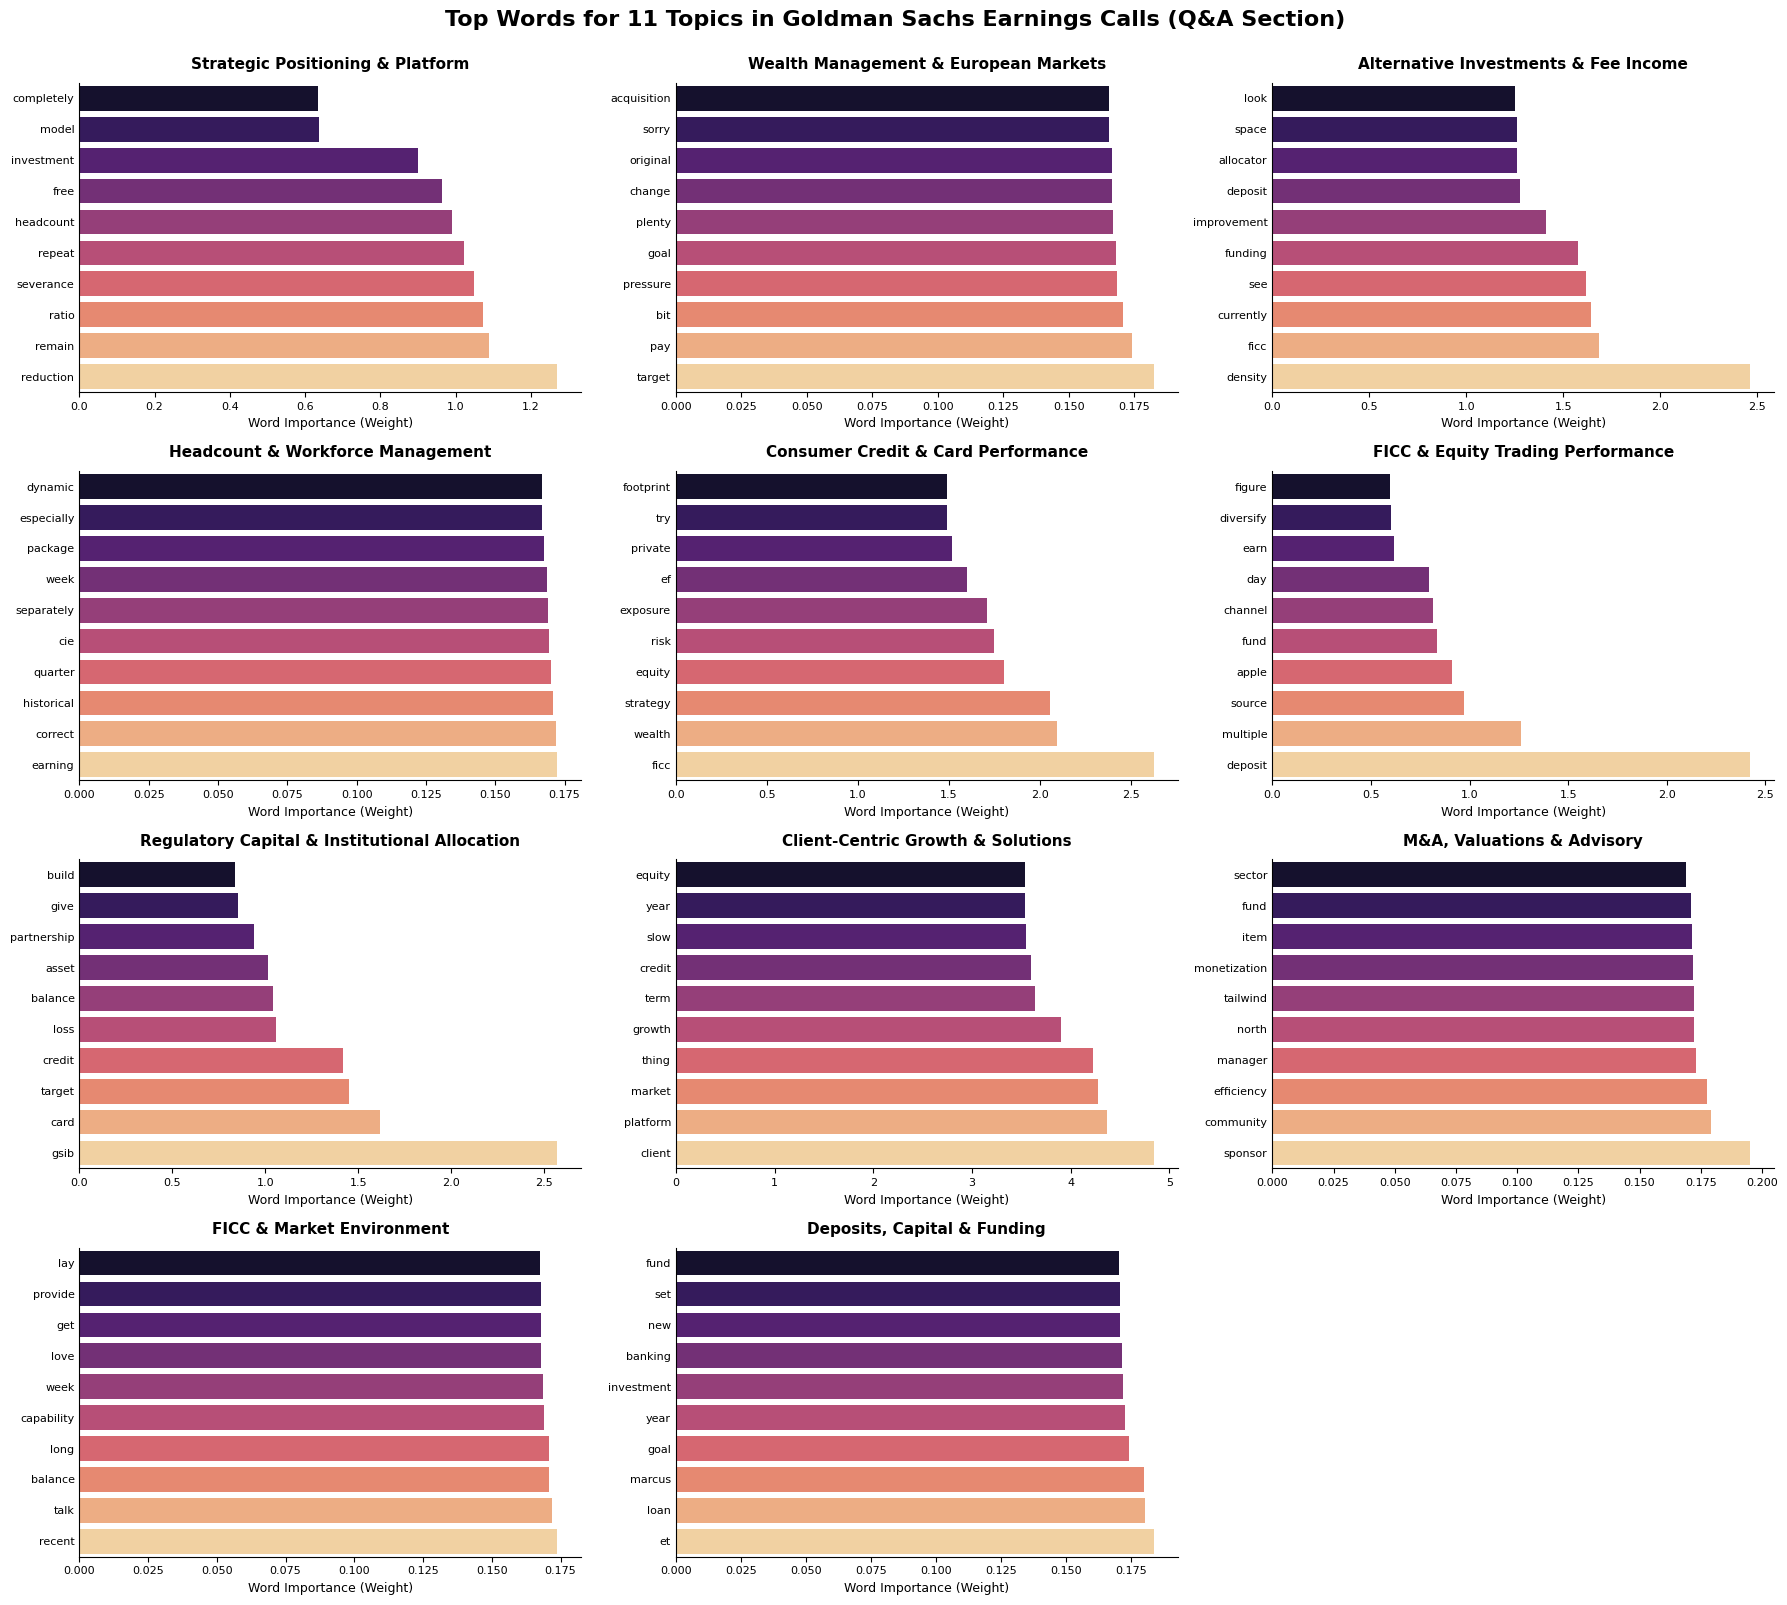


Visual display generated. Please review the plots and verify the topic labels.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
topic_labels_map = {
    0: "Strategic Positioning & Platform",
    1: "Wealth Management & European Markets",
    2: "Alternative Investments & Fee Income",
    3: "Headcount & Workforce Management",
    4: "Consumer Credit & Card Performance",
    5: "FICC & Equity Trading Performance",
    6: "Regulatory Capital & Institutional Allocation",
    7: "Client-Centric Growth & Solutions",
    8: "M&A, Valuations & Advisory",
    9: "FICC & Market Environment",
    10: "Deposits, Capital & Funding"
}

# Assign labels to the topics_data
for topic_info in topics_data_extracted:
    topic_info['label'] = topic_labels_map.get(topic_info['topic_idx'], f"Unlabeled Topic {topic_info['topic_idx']}")

print("\n--- Topics with assigned labels and top words ---")
for topic_info in topics_data_extracted:
    print(f"Topic {topic_info['topic_idx'] + 1}: {topic_info['label']}")
    print(f"  Top Words: {' '.join(topic_info['top_words'])}")
    print("-" * 30)

# --- Visual Display of Topics ---
print("\n--- Generating visual display of topics ---")

n_cols = 3
n_rows = (chosen_num_topics + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 6, n_rows * 4), dpi=100)

for i, topic_info in enumerate(topics_data_extracted):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    df_plot = pd.DataFrame({
        'word': topic_info['top_words'],
        'weight': topic_info['word_weights']
    })
    df_plot = df_plot.sort_values(by='weight', ascending=True)
    sns.barplot(x='weight', y='word', data=df_plot, palette='magma', ax=ax)
    ax.set_title(f"{topic_info['label']}", fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel("Word Importance (Weight)", fontsize=9)
    ax.set_ylabel("")
    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.tick_params(axis='y', length=0)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.suptitle(
    f"Top Words for {chosen_num_topics} Topics in Goldman Sachs Earnings Calls (Q&A Section)",
    y=1.00, fontsize=16, fontweight='bold'
)
plt.show()

print("\nVisual display generated. Please review the plots and verify the topic labels.")


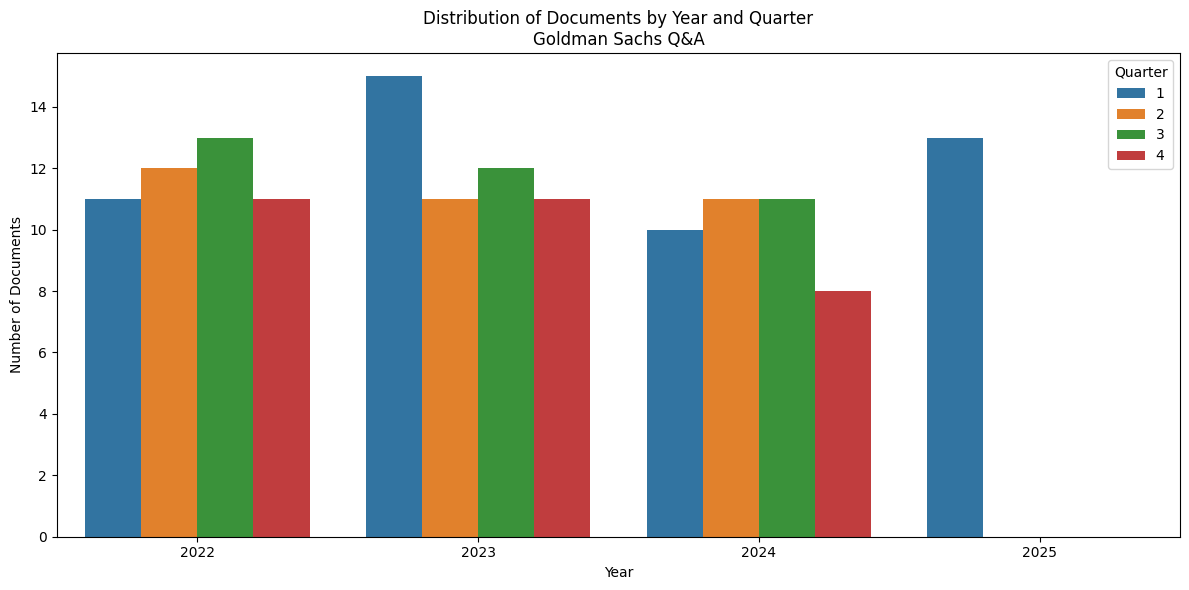

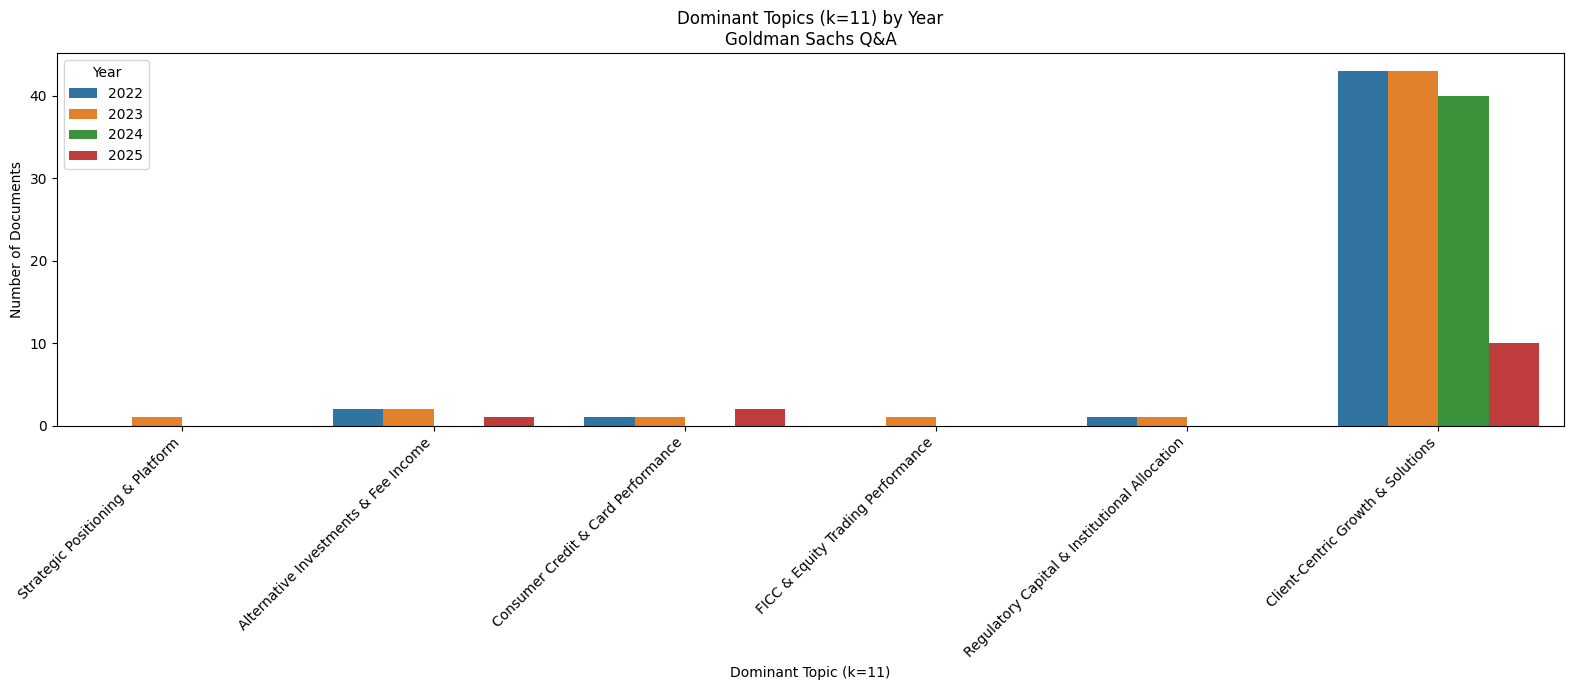

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(
    data=grouped_gs_qna_df,
    x='year',
    hue='quarter',
    palette='tab10'
)
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents by Year and Quarter\nGoldman Sachs Q&A')
plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

# Now, for dominant topics over both year and quarter:
plt.figure(figsize=(16, 7))
sns.countplot(
    data=grouped_gs_qna_df,
    x='dominant_topic_k11',
    hue='year',
    palette='tab10'
)
topic_labels = [topic_labels_map.get(i, f"Topic {i}") for i in sorted(grouped_gs_qna_df['dominant_topic_k11'].unique())]
plt.xticks(ticks=range(len(topic_labels)), labels=topic_labels, rotation=45, ha='right')
plt.xlabel('Dominant Topic (k=11)')
plt.ylabel('Number of Documents')
plt.title('Dominant Topics (k=11) by Year\nGoldman Sachs Q&A')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

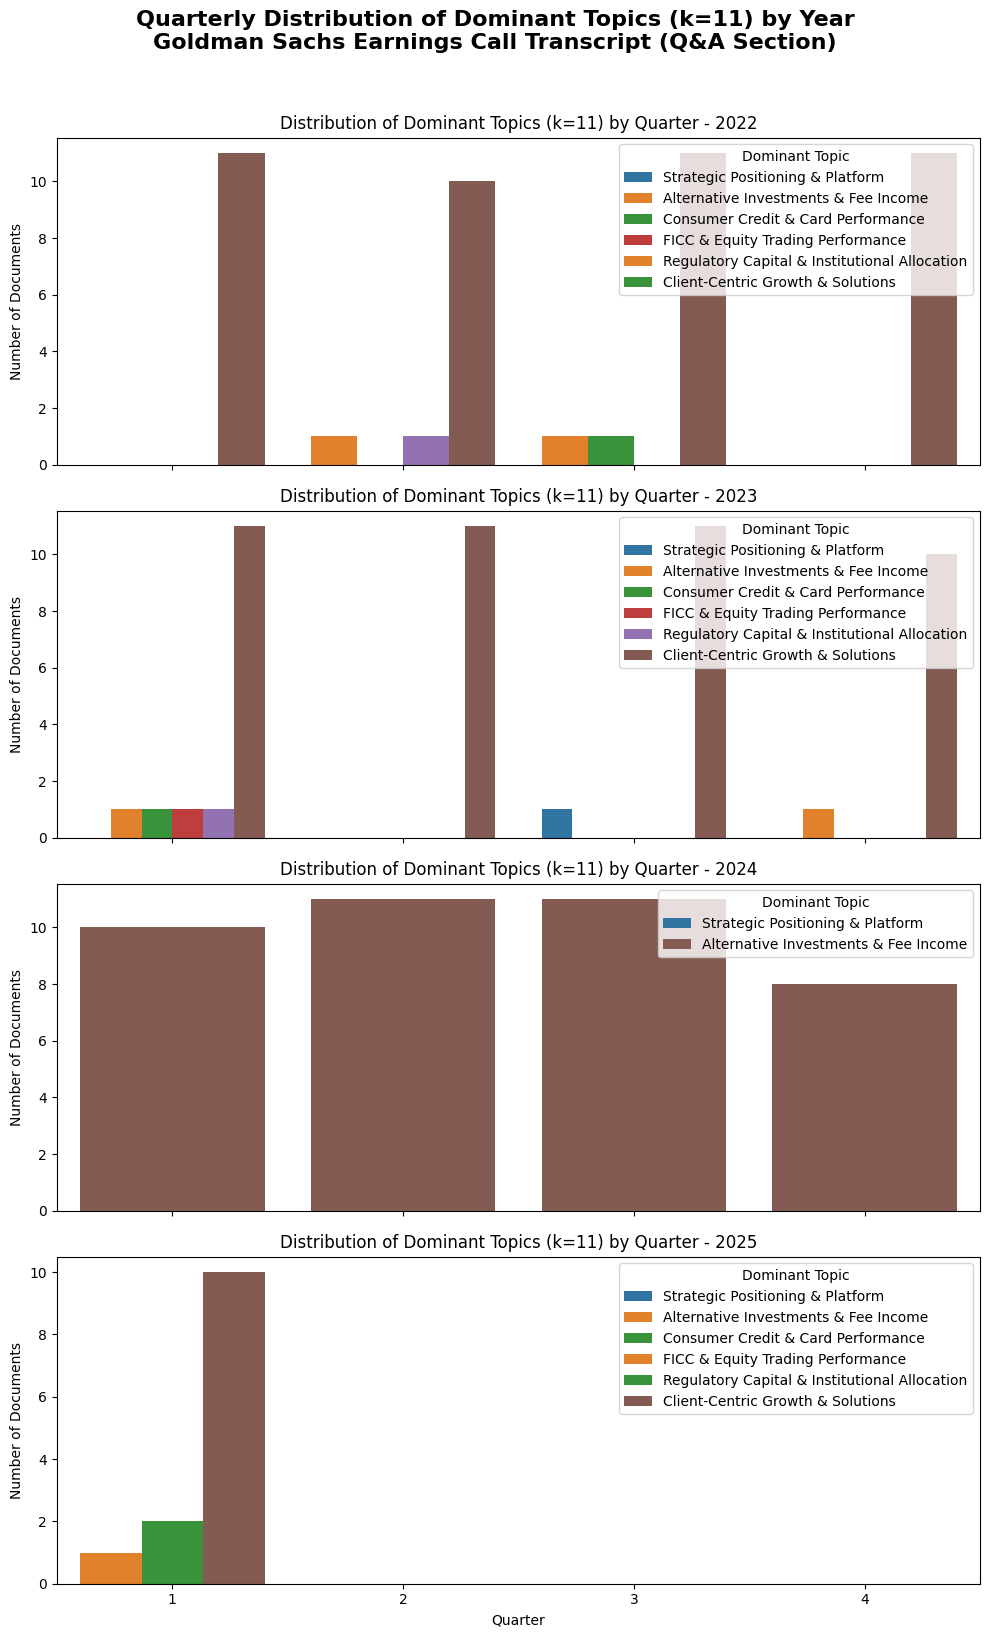

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

years = sorted(grouped_gs_qna_df['year'].unique())
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(10, 4 * n_years), sharex=True)

if n_years == 1:
    axes = [axes]

for idx, year in enumerate(years):
    ax = axes[idx]
    data = grouped_gs_qna_df[grouped_gs_qna_df['year'] == year]
    sns.countplot(
        data=data,
        x='quarter',
        hue='dominant_topic_k11',
        palette='tab10',
        ax=ax
    )
    ax.set_title(f'Distribution of Dominant Topics (k=11) by Quarter - {year}')
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Number of Documents')
    ax.legend(
        title='Dominant Topic',
        loc='upper right',
        labels=[topic_labels_map.get(i, f"Topic {i}") for i in sorted(data['dominant_topic_k11'].unique())]
    )

# Fix color mapping so each topic always has the same color across years
unique_topics = sorted(grouped_gs_qna_df['dominant_topic_k11'].unique())
topic_palette = sns.color_palette('tab10', n_colors=len(unique_topics))
topic_color_dict = {topic: topic_palette[i % len(topic_palette)] for i, topic in enumerate(unique_topics)}

for idx, year in enumerate(years):
    ax = axes[idx]
    data = grouped_gs_qna_df[grouped_gs_qna_df['year'] == year]
    # Use the same color mapping for all years
    sns.countplot(
        data=data,
        x='quarter',
        hue='dominant_topic_k11',
        palette=topic_color_dict,
        ax=ax
    )
    ax.set_title(f'Distribution of Dominant Topics (k=11) by Quarter - {year}')
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Number of Documents')
    handles, labels = ax.get_legend_handles_labels()
    # Always use the same order and labels for legend
    ordered_labels = [topic_labels_map.get(t, f"Topic {t}") for t in unique_topics]
    ax.legend(handles, ordered_labels, title='Dominant Topic', loc='upper right')

plt.suptitle(
    "Quarterly Distribution of Dominant Topics (k=11) by Year\nGoldman Sachs Earnings Call Transcript (Q&A Section)",
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# Save Data Example

In [ ]:
import pandas as pd

target_dir = 'data/temp/'
file_name = 'dummy_test_output_new.csv'
dummy_pf = pd.DataFrame({'from_colab': [IS_COLAB, True, 'hello']})


if OUTPUT_PROCESSED_FILES:
    if IS_COLAB:
        AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
        dummy_pf.to_csv(f"{target_dir}{file_name}", index=False)

        # Configure Git user (important for committing)
        !git config user.email "{GITHUB_EMAIL}"
        !git config user.name "{GITHUB_USERNAME}"
        !git remote set-url origin {AUTHENTICATED_REPO_URL}

        # Add the file to staging
        !git add {target_dir}{file_name}
        print(f"Added '{target_dir}{file_name}' to staging.")

        # Commit the changes
        commit_message = f"Add new data file: {target_dir}{file_name}"
        !git commit -m "{commit_message}"
        print(f"Committed changes with message: '{commit_message}'")
        print(f"Attempted commit with message: '{commit_message}'")

        # Add this line to debug:
        print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

        print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
        !git push --set-upstream origin {REPO_BRANCH} --force
        print("Push command executed. Check output for success or prompt.")
    else:
        dummy_pf.to_csv(f"{target_dir}{file_name}", index=False)
        print("Processed files saved successfully.")